## AUTOENCODER IMPLEMENTATION

This is implementantation of DEC clustering. You should not run the whole code. If you want to run it, go below to "Final Evaluation" part and run from there. 

In [1]:
import keras.backend as K
from keras.layers import Input, Dense, Reshape, Dropout
from keras.models import Model, Sequential, load_model
from keras.engine.topology import Layer, InputSpec
from keras import initializers
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


from keras.datasets import mnist
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
# Creating normalized train and test data 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))

x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 784))


In [3]:
# Hyperparameters
batch_size = 256
num_epochs = 100
initializer = initializers.VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
optimizer = SGD(lr=1, momentum=0.9)

In [6]:
# Autoencoder constructor
def create_autoencoder(input_dim, output_dim, activation1, activation2):
    
    autoencoder = Sequential()
    autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
    autoencoder.add(Dense(output_dim, activation=activation1, kernel_initializer=initializer))
    autoencoder.add(Dropout(0.2))
    autoencoder.add(Dense(input_dim, activation=activation2, kernel_initializer=initializer))
    
    return autoencoder

In [7]:
# Creating autoencoders
autoencoder_1 = create_autoencoder(784, 500, 'relu', 'relu')
autoencoder_2 = create_autoencoder(500, 500, 'relu', 'relu')
autoencoder_3 = create_autoencoder(500, 2000, 'relu', 'relu')
autoencoder_4 = create_autoencoder(2000, 10, 'relu', 'relu')

In [8]:
# Compiling 
autoencoder_1.compile(optimizer=optimizer, loss='mse')
autoencoder_2.compile(optimizer=optimizer, loss='mse')
autoencoder_3.compile(optimizer=optimizer, loss='mse')
autoencoder_4.compile(optimizer=optimizer, loss='mse')

In [9]:
# Show parameters
autoencoder_1.summary()
autoencoder_2.summary()
autoencoder_3.summary()
autoencoder_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               392784    
Total params: 785,284
Trainable params: 785,284
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dens

### Learning autoencoders

In [ ]:
# Getting encoded data from model encoder and input
def get_encoded_data(model, tmp_train_data):
    encoding_function = K.function([model.layers[0].input], [model.layers[1].output])
    return encoding_function([tmp_train_data])[0]

In [ ]:
# Learning first autoencoder
autoencoder_1.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size, shuffle=True)

In [ ]:
# Saving autoencoder to disk
autoencoder_1.save("autoencoder_1")

In [ ]:
# Getting encoded data for second autoencoder
tmp_1_train = get_encoded_data(autoencoder_1, x_train)
tmp_1_train.shape

In [ ]:
# Learning second autoencoder
autoencoder_2.fit(tmp_1_train, tmp_1_train, epochs=num_epochs, batch_size=batch_size, shuffle=True)

In [ ]:
# Saving autoencoder to disk
autoencoder_2.save("autoencoder_2")

In [ ]:
# Getting encoded data for third autoencoder
tmp_2_train = get_encoded_data(autoencoder_2, tmp_1_train)
tmp_2_train.shape

In [ ]:
# Learning third autoencoder
autoencoder_3.fit(tmp_2_train, tmp_2_train, epochs=num_epochs, batch_size=batch_size, shuffle=True)

In [ ]:
# Saving autoencoder to disk
autoencoder_3.save("autoencoder_3")

In [ ]:
# Getting encoded data for fourth autoencoder
tmp_3_train = get_encoded_data(autoencoder_3, tmp_2_train)
tmp_3_train.shape

In [ ]:
# Learning fourth autoencoder
autoencoder_4.fit(tmp_3_train, tmp_3_train, epochs=num_epochs, batch_size=batch_size, shuffle=True)

In [ ]:
# Saving autoencoder to disk
autoencoder_4.save("autoencoder_4")

### Making SAE

In [ ]:
autoencoder_1 = load_model("autoencoder_1")
autoencoder_2 = load_model("autoencoder_2")
autoencoder_3 = load_model("autoencoder_3")
autoencoder_4 = load_model("autoencoder_4")

autoencoder = Sequential()
# Adding encoder parts
inputs = Input(shape=(784,))

x = autoencoder_1.layers[1](inputs)
x = autoencoder_2.layers[1](x)
x = autoencoder_3.layers[1](x)
x = autoencoder_4.layers[1](x)

# Adding decoder part
x = autoencoder_4.layers[3](x)
x = autoencoder_3.layers[3](x)
x = autoencoder_2.layers[3](x)
prediction = autoencoder_1.layers[3](x)

autoencoder = Model(inputs=inputs, outputs=prediction)
autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.summary()

In [ ]:
autoencoder.fit(x_train, x_train, epochs=100, batch_size=batch_size, shuffle=True)

In [ ]:
# Saving autoencoder to disk
autoencoder.save("autoencoder")

In [4]:
def test_restoration(model):
    decoded_imgs = model.predict(x_train)
    get_2nd_layer_output = K.function([model.layers[0].input], [model.layers[4].output])

    for i in range(2):
        print("original: ")
        plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
        plt.show()
        #-------------------
        print("reconstructed: ")
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.show()
        #-------------------
        print("compressed: ")
        current_compressed = get_2nd_layer_output([x_train[i:i+1]])[0][0]
        plt.imshow(current_compressed.reshape(1, 10), cmap='gray')
        plt.show()

original: 


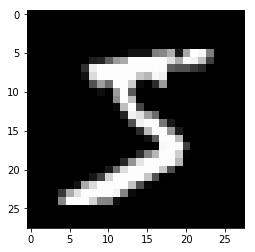

reconstructed: 


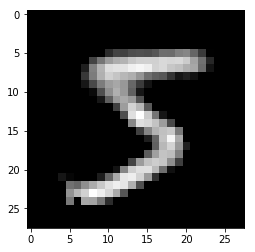

compressed: 


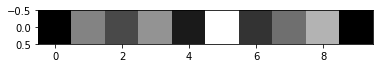

original: 


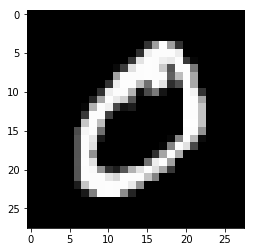

reconstructed: 


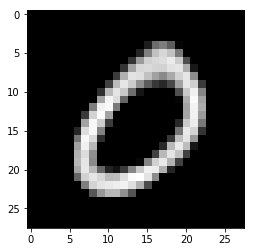

compressed: 


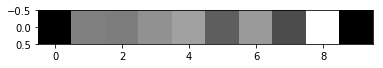

In [5]:
autoencoder = load_model("autoencoder")
test_restoration(autoencoder)

## K-Means clustering

In [ ]:
# Creating K-means model
kmeans = KMeans(n_clusters=10, n_init=20, verbose=0)
kmeans.fit_predict(x_train)

In [ ]:
# Dumping model
pickle.dump(kmeans, open("kmeans.sav", 'wb'))

In [ ]:
# Loading model from disk
kmeans_model = pickle.load(open("kmeans.sav", 'rb'))

In [ ]:
# Calculating cluster accuracy
def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
# Calculating accuracy of pure kmeans
pred_kmeans = kmeans_model.predict(x_train)
cluster_acc(y_train, pred_kmeans)

## K-means plus encoder part

In [ ]:
# Getting encoded data
get_encoder_layer_output = K.function([autoencoder.layers[0].input], [autoencoder.layers[4].output])
x_encoded_train = get_encoder_layer_output([x_train])[0]

In [ ]:
# Creating and learning K-means model with encoded data
kmeans_enc = KMeans(n_clusters=10, n_init=20)
kmeans_enc.fit(x_encoded_train)
print("Finished")

In [ ]:
# Dumping model
pickle.dump(kmeans_enc, open("kmeans_enc.sav", 'wb'))

In [ ]:
# Loading model from disk
kmeans_enc_model = pickle.load(open("kmeans_enc.sav", 'rb'))

In [ ]:
# Evaluation of K-means model with encoded data
pred_kmeans_enc = kmeans_enc_model.predict(x_encoded_train)
cluster_acc(y_train, pred_kmeans_enc)

## DEC implementation

In [ ]:
class ClusteringLayer(Layer):
    "Custom layer for clustering. Performs calcualations according SGD and t-distribution"
    def build(self, input_shape):
        self.c = self.add_weight((10, input_shape[1]), initializer='glorot_uniform', name='clusters')
        self.built = True

    def call(self, z, **kwargs):
        "Calculating t-distribution"
        q = 1 / (1 + (K.sum(K.square(K.expand_dims(z, axis=1) - self.c), axis=2)))
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        return input_shape[0], 10

In [ ]:
# Making clustering layer
clustering_layer = ClusteringLayer()(autoencoder.layers[4].output)
sae_and_cluster_model = Model(inputs=autoencoder.layers[0].input, outputs=clustering_layer)

In [ ]:
sae_and_cluster_model.summary()

In [ ]:
# Compiling model with KL divergence as loss function
sae_and_cluster_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [ ]:
# Initializing cluster with k-means
sae_and_cluster_model.layers[-1].set_weights([kmeans_enc_model.cluster_centers_])

## Training DEC

In [ ]:
# Computing target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
# Initializing variables
loss = 0
index = 0
num_itaration = 8000
update_interval = 100
index_array = np.arange(x_train.shape[0])
y_pred_prev = np.copy(pred_kmeans_enc)
tol = 0.001 # Treshold where to stop iterating

### Iteration

In [ ]:
for ite in range(int(num_iteration)):
    if ite % update_interval == 0:
        q = sae_and_cluster_model.predict(x_train)
        p = target_distribution(q)  

        # Evaluation of accuracy
        y_pred = q.argmax(1)
        if y_train is not None:
            acc = np.round(cluster_acc(y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iteration %d: acc = %.5f' % (ite, acc), ' ; loss=', loss)

        # Checking if tolerance limit is reached
        delta_label = np.sum(np.not_equal(y_pred, y_pred_prev)).astype(np.float32) / y_pred.shape[0]
        y_pred_prev = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]
    loss = sae_and_cluster_model.train_on_batch(x=x_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0

In [ ]:
# Saving DEC model to disk
sae_and_cluster_model.save("sae_and_cluster")

## Final Evaluation (Start here, and run)

Final evaluation part, it will load all needed saved models and evaluate them.

In [1]:
import keras.backend as K
from keras.layers import Input, Dense, Reshape, Dropout
from keras.models import Model, Sequential, load_model
from keras.engine.topology import Layer, InputSpec
from keras import initializers
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


from keras.datasets import mnist
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
class ClusteringLayer(Layer):
    def build(self, input_shape):
        self.c = self.add_weight((10, input_shape[1]), initializer='glorot_uniform', name='clusters')
        self.built = True

    def call(self, z, **kwargs):
        q = 1 / (1 + (K.sum(K.square(K.expand_dims(z, axis=1) - self.c), axis=2)))
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        return input_shape[0], 10

In [3]:
# Calculating cluster accuracy
def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [4]:
# Computing target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [5]:
# loading all the needed models
sae_and_cluster_model = load_model("sae_and_cluster", custom_objects={'ClusteringLayer': ClusteringLayer})
kmeans_model = pickle.load(open("kmeans.sav", 'rb'))
kmeans_enc_model = pickle.load(open("kmeans_enc.sav", 'rb'))
autoencoder = load_model("autoencoder")

In [6]:
# Initializing variables
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))

x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 784))

In [7]:
q = sae_and_cluster_model.predict(x_train)
p = target_distribution(q)  

# Getting encoded data
get_encoder_layer_output = K.function([autoencoder.layers[0].input], [autoencoder.layers[4].output])
x_encoded_train = get_encoder_layer_output([x_train])[0]

pred_kmeans_enc = kmeans_enc_model.predict(x_encoded_train)
pred_kmeans = kmeans_model.predict(x_train)

# evaluate the clustering performance
y_pred = q.argmax(1)
acc = np.round(cluster_acc(y_train, y_pred), 5)
print('DEC: acc = %.5f' % acc)
print('K-means and encoder: acc %.5f' % cluster_acc(y_train, pred_kmeans_enc))
print('K-means: acc %.5f' % cluster_acc(y_train, pred_kmeans))

DEC: acc = 0.86013
K-means and encoder: acc 0.77904
K-means: acc 0.53236


## DEC: acc = 0.86013
## K-means and encoder: acc 0.77904
## K-means: acc 0.53236